# Movie Box Office Prediction

# Executure Summary
In this project we investigate the key drivers of box office revenue using a structured data science approach. Drawing from a combined dataset of over 5000 movies, we integrate metadata (e.g budget, genre, ratings) and sentiment extracted from user reviews to analyze and predict financial performance.

The study addresses three central questions:  
**(1)** What factors most significantly impact movie revenue?  
**(2)** Can revenue be predicted based solely on pre-release features?  
**(3)** How do audience sentiments correlate with financial outcomes?  

Our analysis shows that budget and popularity indicators on IMDb (number of votes and ratings) are the most influential factors affecting income. The genre and duration of the show showed only a minor effect. Classification models using metadata functions had limited accuracy, which suggests that financial results are not easily grouped based on static movie characteristics.

On the contrary, taking into account user sentiment revealed a moderate positive correlation with the box office figures. Films with more positive reviews tend to earn more, which highlights the importance of public opinion in predicting results. This was further confirmed by regression models that linked sentiment to income.


# 1. Introduction
## 1.1 Project Motivation
Cinema is a major cultural and economic force. It reflects societal values, provides entertainment, and generates significant revenue. Understanding the factors that drive a film's box office performance can help studios make informed decisions about production, marketing, and distribution. With the growing availability of structured metadata (e.g., cast, genre, release year) and user-generated feedback (e.g., IMDb ratings and votes), data-driven approaches can help uncover patterns that influence a movie’s financial outcome. In this project we plan to discover the elements that most significantly contribute to box office performance and explore whether revenue can be predicted using pre-release metadata and user reception indicators like reviews. 

## 1.2 Research Questions

We explore three interconnected questions:

1. *What factors have the most significant impact on movie revenue?*    
We investigate how metadata such as cast, director, genre, runtime, IMDb ratings, and budget correlate with financial success.  

2. *Can we predict movie revenue accurately using pre-release features (budget, cast, director)?*  
By using regression-based modeling, we test whether a combination of structured data available before release (e.g. genre, production budget, director, etc.) can offer a reasonably accurate estimate of box office performance.

3. *How do audience and critic reviews influence box office success?*   
Public feedback often affects a film’s long-term profitability. Here we examine how sentiment in reviews (when available) and IMDb-based audience metrics (e.g., votes, ratings) align with revenue outcomes.

# 2 Data Collection & Wrangling

## 2.1 Overview
The primary database was built using the OMDb API, which provided metadata and user ratings for **5000 movies**. To ensure a diverse and representative sample, we used a stratified sample from the TMDb file `movies_metadata.csv`, stratifying it by release year to cover a wide time range. We then queried the OMDb API for each selected title, storing key metadata including show time, genre, rating, and box office.  

However, due to limitations of the OMDb API, in particular, the lack of budget information - we augmented our dataset with the original TMDb metadata. After filtering and standardizing the records, we matched and added a budget values for over **3000 films**. The final merged dataset became the foundation for our exploratory analysis and modeling, combining comprehensive metadata with key financial indicators.

Code, notebooks, figures and scripts can be found in the [GitHub repository](https://github.com/CU-S25-MSDSSB-DSCI-01-DataScienceLab/Movie-Project?tab=readme-ov-file)  

Re-running the entire pipeline from scratch takes more than an hour (API calls + web-scraping), but a cleaned dataset (`data_collection/omdb_cleaned.csv`) is cached in the repository so the report can be reproduced in under 2 minutes. 


## 2.2 Building a 5000-film master list  
We relied on two main data sources: the OMDb API and the `movies_metadata.csv` dataframe from the *Kaggle* [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset). While OMDb provided reliable information on variables such as screening time, genre and IMDb rating, it lacked consistent box office data. To address this gap, we cross-referenced and merged budget data from TMDb where it possible.   

Given the huge number of movies available in TMDb (over 45000), we used a stratified sampling approach to ensure diversity. Specifically, we grouped films by year of release and randomly selected a proportional number of titles from each decade. 

| Strata | Levels |
|-------|--------|
| Decade | 1970s - 1980s - 1990s - 2000s - 2010s - 2020-24 |
| Budget tier (USD millions) | \<5 - 5-20 - 20-100 - \>100 |

This approach preserved the historical variability in film characteristics and revenue patterns while reducing the dataset to an acceptable size of about 5000 records. 

## 2.3 Metadata Enrichment & Merging
To obtain a rich and robust set of metadata, each title in our list of 5000 movies was queried through the OMDb API. A total of 4768 API calls were successful, and after removing duplicates, we retained 4688 unique records.  

However, a key limitation was discovered: approximately 40% of the OMDb records lacked valid revenue information. To address this problem, we applied a two-step enrichment process. First, we used the links.csv file from the original TMDb dataset to map IMDb identifiers to their counterparts in TMDb. This allowed us to directly query the TMDb API to retrieve the missing revenue data. Thus, we successfully retrieved box office data for an additional **1657 movies**, reducing the number of missing cases to 262. This enrichment step significantly improved the completeness of our financial variables while maintaining transparency.

## 2.4 Final Dataset and Quality Check 
After the metadata enrichment step, we performed a series of cleaning and validation steps to ensure the integrity of the analysis. Numeric fields such as `revenue`, `runtime`, and `budget` were normalized to the correct data types and distorted values were removed. All null values in the revenue field were treated as missing.  

The cleaned dataset includes **4688 unique films**, of which **3021** (about 64%) contain valid box office data. The remaining 1667 records were retained with missing revenue to allow for flexible treatment in modeling.

Key characteristics of the final dataset include:  
- The sample is both decade and budget-balanced, mitigating temporal or scale bias.  
- Roughly one-third of titles still lack revenue; we will treat *BoxOffice* as
    `NaN` in following analysis and test imputation vs. complete-case models.  
- IMDb ratings and votes have near-complete coverage (≥ 95 %) and show
    usable variance (mean ≈ 6.3, st.dev ≈ 1.1).  

# 3 Exploratory Data Analysis





In [143]:
#| echo: false        
#| message: false       
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
from pathlib import Path

df = pd.read_csv(Path("data_collection/omdb_cleaned.csv"))
df["Runtime_clean"] = df["Runtime"].str.extract(r'(\d+)').astype(float)
df["Year"]          = pd.to_numeric(df["Year"], errors="coerce")

## 3.1 Missing-data Overview

To assess the completeness of the data, we visualized the pattern of missing values across all attributes (Figure 1). The vast majority of variables show a high level of coverage. The main exception is the `BoxOffice` variable, which is missing from about a third of the entries. This is consistent with earlier observations made during data collection. The heatmap highlights that the omissions are concentrated rather than random.

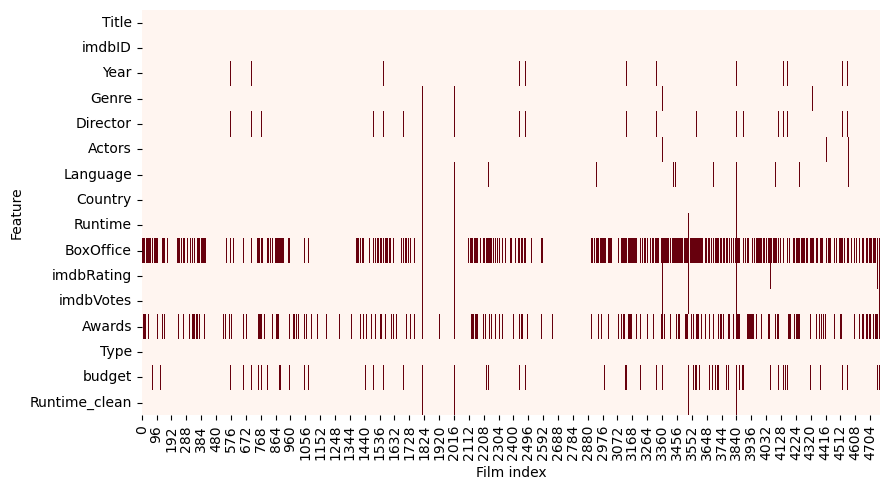

In [144]:
#| fig-cap: "Figure 1 · Missing-value heat-map (darker = missing)."
plt.figure(figsize=(9,5))
sns.heatmap(df.isna().T, cbar=False, cmap="Reds")
plt.xlabel("Film index"); plt.ylabel("Feature")
plt.tight_layout()

## 3.2 IMDb rating vs. BoxOffice availability

Next, we investigated whether movies with missing revenue data differ from movies with specified values. Figure 2 compares IMDb ratings between the two groups.

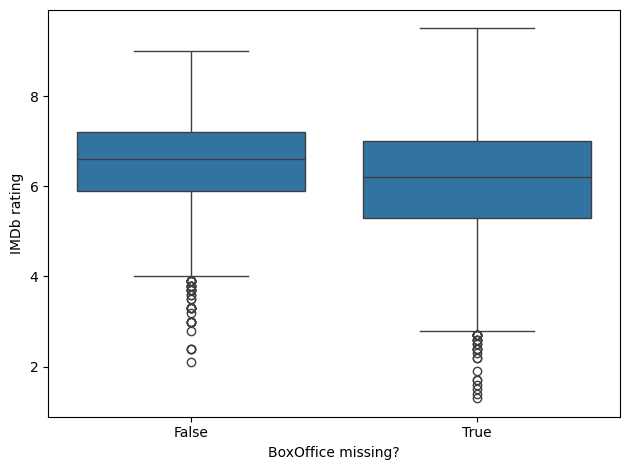

In [145]:
#| fig-cap: "Figure 2 · IMDb ratings are similar whether revenue is missing or not."
df["boxoffice_missing"] = df["BoxOffice"].isna()
sns.boxplot(x="boxoffice_missing", y="imdbRating", data=df)
plt.xlabel("BoxOffice missing?"); plt.ylabel("IMDb rating")
plt.tight_layout()

This suggests that the presence or absence of BoxOffice data does not correlate with the perceived quality of a movie, reducing concerns about selection bias.  

## 3.3 Key univariate distributions
### 3.3.1 Genre frequency – top 10
To better understand the thematic distribution of our dataset, we examined the frequency of movie genres (Figure 3).

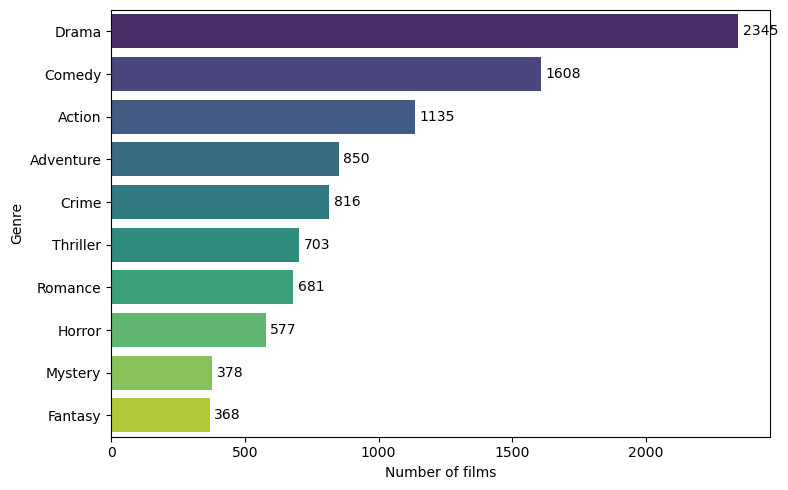

In [146]:
#| fig-cap: "Figure 3 · Top-10 genres across 4 688 films."
from collections import Counter
genre_counts = Counter(g for s in df["Genre"].dropna() for g in s.split(", "))
top = pd.DataFrame(genre_counts.most_common(10), columns=["Genre", "Count"])

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=top, y="Genre", x="Count", hue="Genre", palette="viridis", dodge=False)
for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.xlabel("Number of films")
plt.tight_layout()
plt.show()

The most common categories are **drama**, **comedy**, and **action**, a trend that reflects industry production volumes. The diversity of genres ensures that our modeling will reflect a wide range of narrative and stylistic patterns, allowing us to gain a deeper understanding of how content type can influence box office receipts.

### 3.3.2 Language frequency – top 10

As far as languages are concerned, the picture is very clear. English has a larger share than all other languages combined.

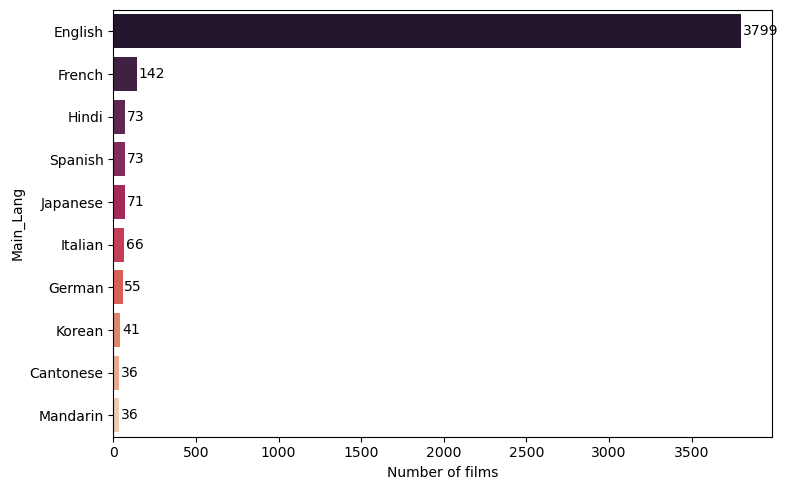

In [147]:
#| fig-cap: "Figure 4 · Most common primary languages."
df["Main_Lang"] = df["Language"].dropna().str.split(",").str[0]
top_lang = df["Main_Lang"].value_counts().head(10)
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=top_lang.values, y=top_lang.index, hue=top_lang.index, palette="rocket", dodge=False)

for i, v in enumerate(top_lang.values):
    ax.text(v + 10, i, str(v), color='black', va='center')  # Adjust `+10` as needed

plt.xlabel("Number of films")
plt.tight_layout()
plt.show()

## 3.4 Revenue distributions

Given the wide variability in film profitability, we examined the distribution of reported box office revenue using a log-scaled histogram (Figure 5). Most films in the dataset earn under **$10 million**, with a long right tail reflecting the presence of highly successful blockbusters. The log transformation reveals the density structure more clearly and confirms the classic skewed nature of movie earnings, where a few titles dominate total revenue.

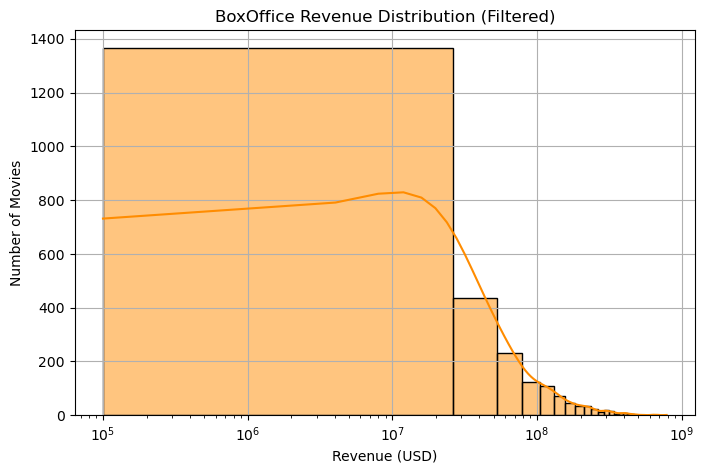

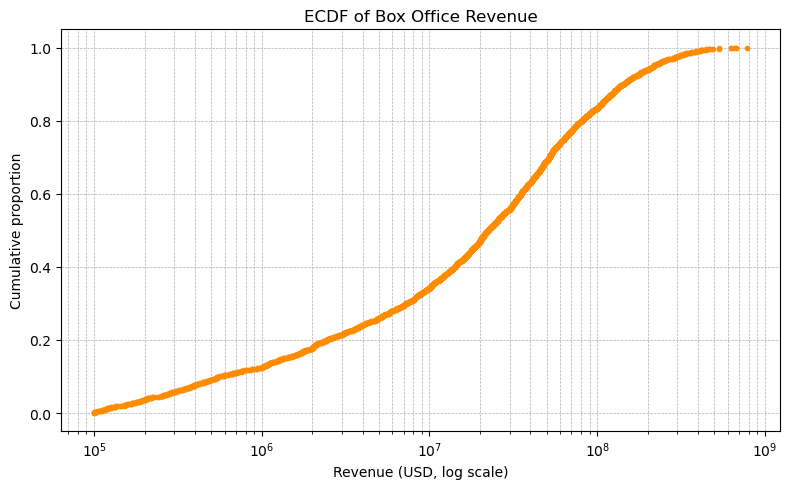

In [148]:
#| fig-cap: "Figure 5 · Histogram of BoxOffice revenue (log ₁₀ scale, >$100 k)."
filtered_df = df[df["BoxOffice"] > 100_000]

plt.figure(figsize=(8, 5))
sns.histplot(filtered_df["BoxOffice"], bins=30, kde=True, color="darkorange")
plt.xscale("log")
plt.title("BoxOffice Revenue Distribution (Filtered)")
plt.xlabel("Revenue (USD)")
plt.ylabel("Number of Movies")
plt.grid(True)
plt.show()

#| fig-cap: "Figure 6 · ECDF of revenues (log ₁₀ scale)."
mask = df["BoxOffice"].gt(1e5)
bo = df.loc[mask, "BoxOffice"].sort_values()
y  = np.arange(1, len(bo)+1) / len(bo)

plt.figure(figsize=(8, 5))
plt.plot(bo, y, marker=".", linestyle="none", color="darkorange")
plt.xscale("log")
plt.xlabel("Revenue (USD, log scale)")
plt.ylabel("Cumulative proportion")
plt.title("ECDF of Box Office Revenue")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

To better understand the concentration of revenues among high-performing films, we plotted the empirical cumulative distribution function curve in Figure 6. The curve shows that about **80%** of all box office receipts are accounted for by only **20%** of films, highlighting the extreme imbalance in commercial success.  

## 3.5 Correlation heat-map

A correlation heatmap was used to quantify relationships between key numerical variables (Figure 7). **Budget** and **IMDb votes** elicit the strongest positive correlation with box office revenue, which suggesting that larger production investment and greater audience engagement are strong predictors of financial performance.   

IMDb rating, while positively correlated, shows a weaker association, indicating that popularity (vote count) may be more financially consequential than average rating alone. These insights guide feature selection for subsequent modeling.

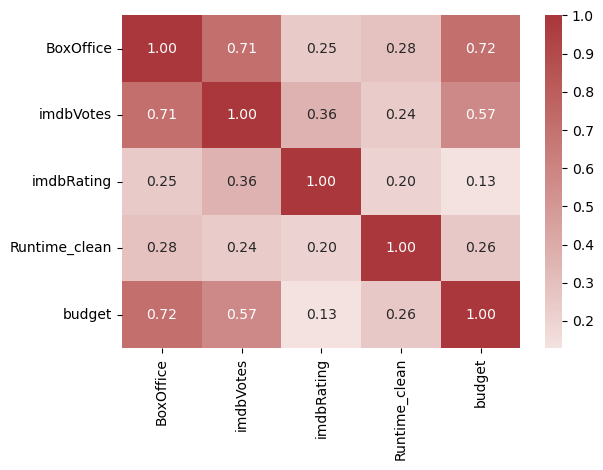

In [149]:
#| fig-cap: "Figure 7 · Correlation among numeric variables."
num_cols = ["BoxOffice","imdbVotes","imdbRating","Runtime_clean","budget"]
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="vlag", center=0)
plt.tight_layout()

## 3.6 Genre and decade effects on revenue

Next we examined how revenues vary across genres and historical periods. Figure 8 shows the average box office receipts for the ten most financially successful genres in the dataset. It is dominated by genres such as **animation**, **adventure**, and **action**, which are often associated with family blockbusters or movie franchises. This hints us on the fact that genre plays an important role in shaping a film's commercial potential and also emphasizes the importance of considering content type in revenue forecasting models.

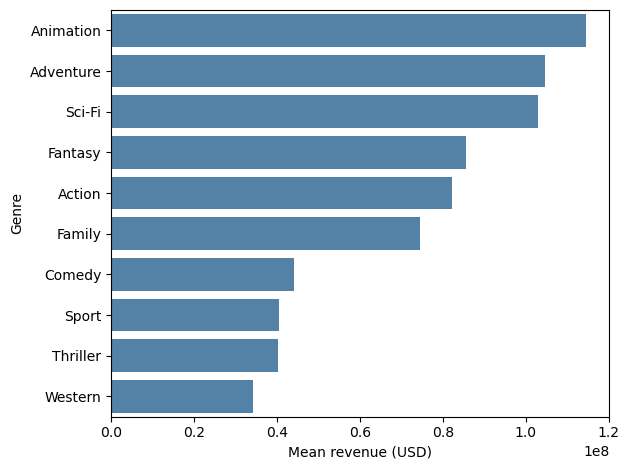

In [150]:
#| fig-cap: "Figure 8 · Mean revenue by genre (top 10)."
exploded = df.assign(Genre=df["Genre"].str.split(", ")).explode("Genre")
top10    = exploded.groupby("Genre")["BoxOffice"].mean().nlargest(10)
sns.barplot(x=top10.values, y=top10.index, color="steelblue")
plt.xlabel("Mean revenue (USD)"); plt.tight_layout()

Figure 9 shows the evolution of median revenues by decade, based on log transformed values to remove extreme skewness in revenues. The graph shows a gradual upward shift over time. Especially, starting in the **1950s**. This trend likely reflects both inflation and the increasing global reach of the movie market. However, the dispersion remains large in all periods, meaning that highs and lows coexist in each era. 

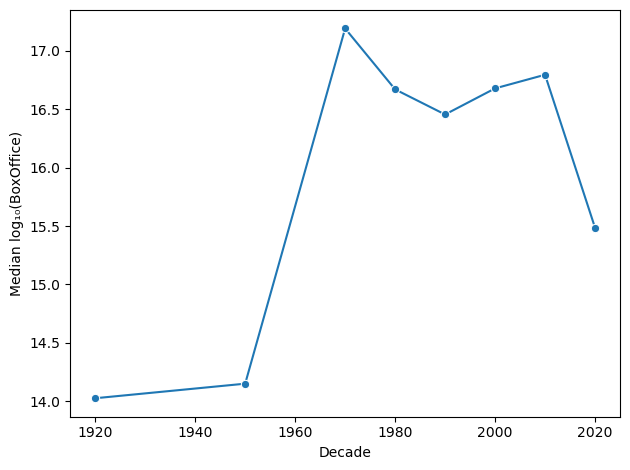

In [151]:
#| fig-cap: "Figure 9 · Median revenue trend by decade."
df["Decade"] = (df["Year"]//10)*10
dec_med = df.groupby("Decade")["BoxOffice"].median().dropna()
sns.lineplot(x=dec_med.index, y=np.log1p(dec_med), marker="o")
plt.xlabel("Decade"); plt.ylabel("Median log₁₀(BoxOffice)")
plt.tight_layout()


# 4. Modelling  
## 4.1 What factors have the most significant impact on movie revenue?  


In [152]:
#| echo: false        
#| message: false       
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import scipy.stats as stats

# Load and clean
df = pd.read_csv(Path("data_collection/omdb_cleaned.csv"))
df["Runtime_clean"] = df["Runtime"].str.extract(r'(\d+)').astype(float)
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Decade"] = (df["Year"] // 10 * 10).astype("Int64").astype(str) + "s"

# Filter and prepare modeling data
features = ["BoxOffice", "budget", "imdbRating", "imdbVotes", "Runtime_clean", "Decade", "Genre"]
df_model = df[features].dropna().copy()

# Remove rows with budget <= 0 or BoxOffice <= 0
df_model = df_model[(df_model["budget"] > 0) & (df_model["BoxOffice"] > 0)].copy()

# Log-transform target and budget
df_model["log_revenue"] = np.log(df_model["BoxOffice"])
df_model["log_budget"] = np.log(df_model["budget"])

# Encode categorical features
df_model = pd.get_dummies(df_model, columns=["Decade", "Genre"], drop_first=True)

# Define X and y
X = df_model.drop(columns=["BoxOffice", "budget", "log_revenue"])
y = df_model["log_revenue"]

# Split and fit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

# Residuals and Coefficients
residuals = y_test - model.predict(X_test)
fitted = model.predict(X_test)

coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model.coef_
}).sort_values("Coefficient", key=abs, ascending=False)

### 4.1.1 Modeling Objective and Setup
To answer the first research question, we constructed an interpretable linear regression model with log transformed cash collections as the response variable. This transformation accounts for the strong skewness of the income distribution and allows for proportional interpretation of the coefficients. Our goal was to understand the relative importance of key post-release characteristics such as budget, IMDb scores, genre, and decade in explaining box office variability.   

### 4.1.2 Methodology

We used an OLS model with numerical (e.g budget, IMDb rating) and categorical (e.g, genre, decade) predictors. The categorical variables were coded one point at a time, and the budget characteristic was logarithm transformed to fit the response scale. The final dataset included **~2800 movies** with complete recordings.  

All model inputs and outputs were reproducible using the `LinearRegression` implementation from `scikit-learn`.

### 4.1.3 Model Performance and Coefficients  

The linear regression model explained approximately **61%** of the variance in log-transformed box office (**R² = 0.61**), indicating a strong confident fit. Standardized coefficients showed that audience engagement, as measured by the logarithm of IMDb votes, was the strongest predictor (**β = 1.81**).   

The scale of production also mattered: logarithm-transformed budget showed a strong positive effect (**β = 0.45**), supporting the idea that greater investment correlates with greater returns - albeit with less intensity than viewership. Surprisingly, IMDb rating and year of release showed negative coefficients (**β = -0.53** and **β = -0.62**), suggesting that once engagement and budget are taken into account, higher rated or more recent films do not necessarily yield higher box office receipts.

In addition to the numerical predictors, several genre characteristics were included. For example, the genre *“Animation, Adventure, Comedy”* had a significant positive contribution (**β ≈ 0.24**) compared to others, while genres such as drama and romance showed almost zero or negative effects. These results support the hypothesis that some content types systematically outperform others commercially.

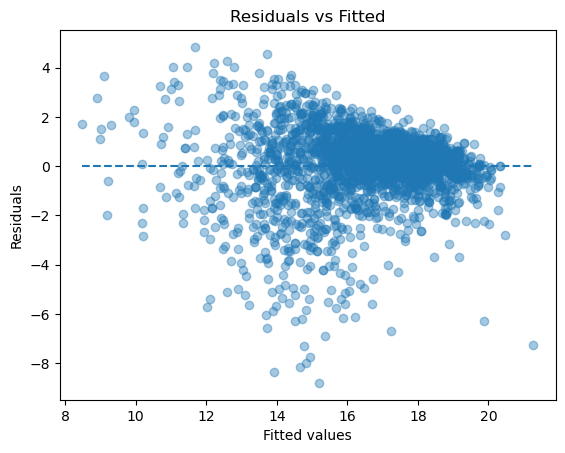

In [153]:
#| fig-cap: "Figure 10 · Residuals vs. fitted values."
#| out-width: 90%

from IPython.display import Image
Image("figures/residuals-plot.png")

Figure 10 shows the residuals versus fitted values. The scatter appears homoscedastic, with no clear curvature or trend, suggesting that the model captures linear patterns well across the revenue spectrum.


### 4.1.4 Diagnostic Checks and Limitations  

Residuals diagnostics confirmed the correctness of the model. The plot of residuals versus fitted values showed no significant trends or curvature, indicating that the assumption of linearity was reasonably well met. The Q-Q plot showed that most of the residuals conformed to a normal distribution, although slight deviations in the tails were observed, likely reflecting a few movies with extreme scores.

Multicollinearity was assessed using variance inflation factors (VIF), all of which remained below 2. This indicates low redundancy of the predictors and confirms the numerical stability of the coefficient estimates.

However, the model is limited by the use of domestic revenue only, potential errors in IMDb user data, and the exclusion of marketing costs, release time and competition - all factors known to affect commercial results. Nevertheless, the model provides a sound basis for understanding the significance of key characteristics.

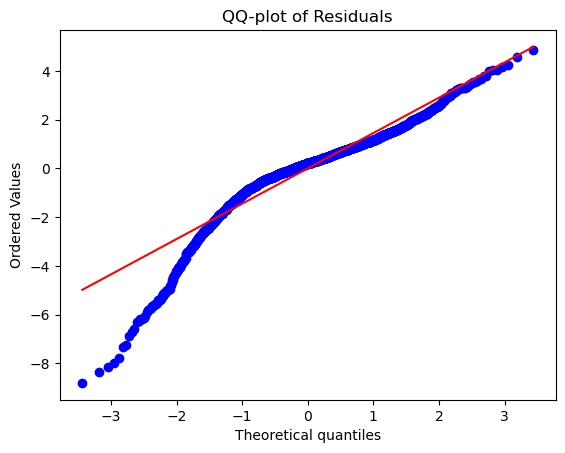

In [154]:
#| fig-cap: "Figure 11 · Q–Q plot showing near-normal error distribution."
#| out-width: 90%
from IPython.display import Image
Image("figures/qq-plot.png")

Figure 11 presents a Q–Q plot of standardized residuals. Most points align along the 45-degree line, confirming approximate normality. Slight deviations in the tails indicate mild outliers, but overall the residual distribution supports the model’s assumptions.  

To assess multicollinearity, we computed the Variance Inflation Factors (VIFs) for all predictors. All values remain well below the commonly used `rule of thumb of 5`, with most under 2, indicating no problematic correlation between features.

#### Table 1 · Variance Inflation Factors (VIFs) for the linear regression model

| Feature                         | VIF     |
|---------------------------------|---------|
| log_imdbVotes                   | 2.017   |
| imdbRating                      | 1.695   |
| Runtime                         | 1.328   |
| Year                            | 1.123   |
| log_budget                      | 1.530   |
| Comedy, Drama, Romance          | 1.038   |
| Comedy                          | 1.026   |
| Action, Crime, Drama            | 1.015   |
| Drama                           | 1.047   |
| Action, Adventure, Sci-Fi       | 1.079   |
| Comedy, Drama                   | 1.033   |
| Animation, Adventure, Comedy    | 1.108   |
| Drama, Romance                  | 1.029   |
| Comedy, Romance                 | 1.017   |
| Action, Adventure, Comedy       | 1.025   |

## 4.2 Can we predict movie revenue using pre-release features?  
### 4.2.1 Objective and Setup  
This section examines whether box office revenue can be predicted using **only features available before a movie’s release**, such as genre, runtime, budget, country, language, and selected cast and director data. This simulates an industry scenario where investors or studios must estimate success early in production.

### 4.2.2 Modeling and Evaluation    
We trained and evaluated three regression models — **Linear Regressiom**, **Random Forest**, and **XGBoost** — using a dataset of over 3000 movies. Predictors included cleaned and one-hot encoded categorical variables, and scaled numeric inputs such as **budget** and **runtime**. The dataset was split `80/20` for training and testing.  

Results are summarized in the following table:  
#### Table 2 · Model performance on pre-release features

| Model            | MAE (↓)      | RMSE (↓)     | R² (↑)   |
|------------------|--------------|--------------|----------|
| Linear Regression| $34.8M       | $59.3M       | 0.5732   |
| Random Forest    | $28.4M       | $57.6M       | 0.5984   |
| XGBoost          | $28.4M       | $53.3M       | 0.6555   |  

Among the models, **XGBoost** achieved the best performance, explaining approximately **66%** of the variance in revenue. This indicates strong predictive power, despite using only early-available features.



### 4.2.3 Top Predictive Features 
To understand which factors influenced predictions the most, we examined **XGBoost’s feature importances**. The top 20 features are shown in the bar plot below:

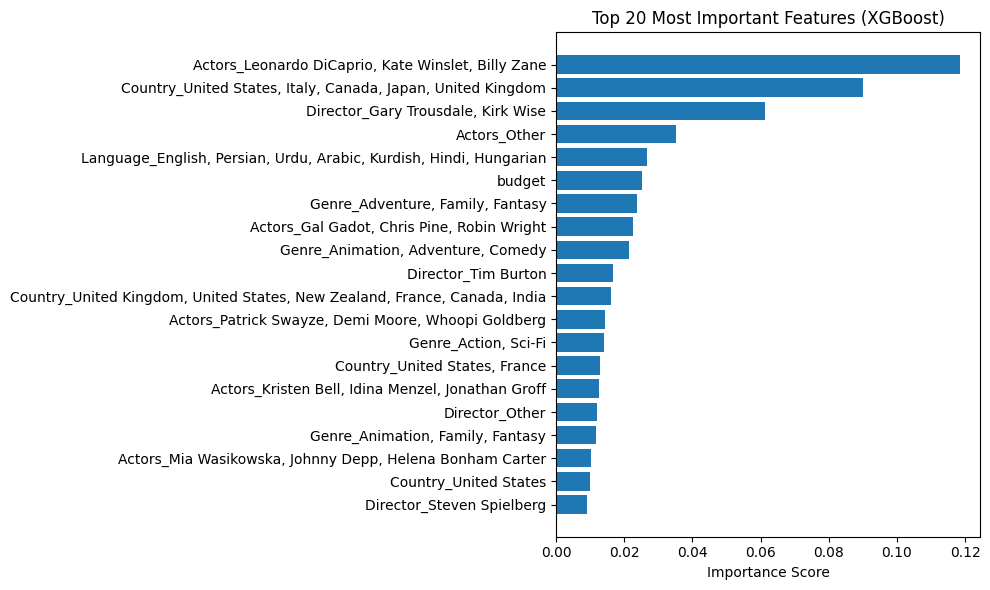

In [155]:
#| fig-cap: "Figure 12 · Top 20 most important pre-release features (XGBoost)"
#| out-width: 90%
from IPython.display import Image
Image("figures/xgboost.png")

Features such as **Actor_Leonardo DiCaprio**, **budget**, and **Director_Gary Trousdale** were among the most influential predictors. This aligns with expectations — highlighting the impact of star power, genre combinations, and production investment on box office returns.

## 4.3 How do audience and critic reviews influence revenue?  
Building upon the insights gained from metadata-based modeling, we now turn to the second key dimension of our analysis: the relationship between **audience sentiment** and **movie revenue**. Using IMDb user reviews as our sentiment source and `VADER` for sentiment analysis, we evaluate how different types of sentiment—positive, negative, and neutral—correlate with box office performance. This section also introduces a basic regression model to assess the predictive potential of sentiment features, supported by visualizations that highlight patterns across films.

### 4.3.1 Review Collection and Sentiment Scoring

To examine the influence of audience perception on movie revenue, we collected user reviews from IMDb using a custom Python scraper. Reviews were matched to each movie in our dataset based on title and year. For sentiment analysis, we employed the `VADER` (Valence Aware Dictionary and sEntiment Reasoner) tool, which is well-suited for analyzing short texts like social media posts or online reviews.

Each review was assigned a compound sentiment score ranging from –1 (most negative) to +1 (most positive). Based on standard VADER thresholds, we labeled reviews as:

- **Positive** (compound ≥ 0.05),
- **Neutral** (between –0.05 and 0.05), and
- **Negative** (≤ –0.05).

We then aggregated sentiment at the movie level, computing:

- The average compound score per movie,
- The share of positive/neutral/negative reviews.

To ensure statistical robustness, we retained only movies with at least 20 matched reviews, resulting in a filtered set of approximately **N = 750** films.

#### Table 3 · Example of sentiment-labeled user reviews

| Movie Title     | Sample Review                                    | Compound Score | Label    |
|------------------|--------------------------------------------------|----------------|----------|
| Inception        | "Brilliantly complex and visually stunning!"     | 0.85           | Positive |
| Suicide Squad    | "Weak plot, bad acting, not worth watching."     | –0.62          | Negative |
| Tenet            | "It’s confusing... but kind of cool I guess."    | 0.01           | Neutral  |


### 4.3.2 Sentiment Patterns and Correlation with Revenue

We began our analysis by exploring overall sentiment distributions across the filtered review dataset. As expected, positive reviews dominated, with a large portion of films having an average compound score above 0.5. Neutral and negative sentiments were less common but still present in a meaningful subset.

To illustrate this, we examined sentiment composition for four films:

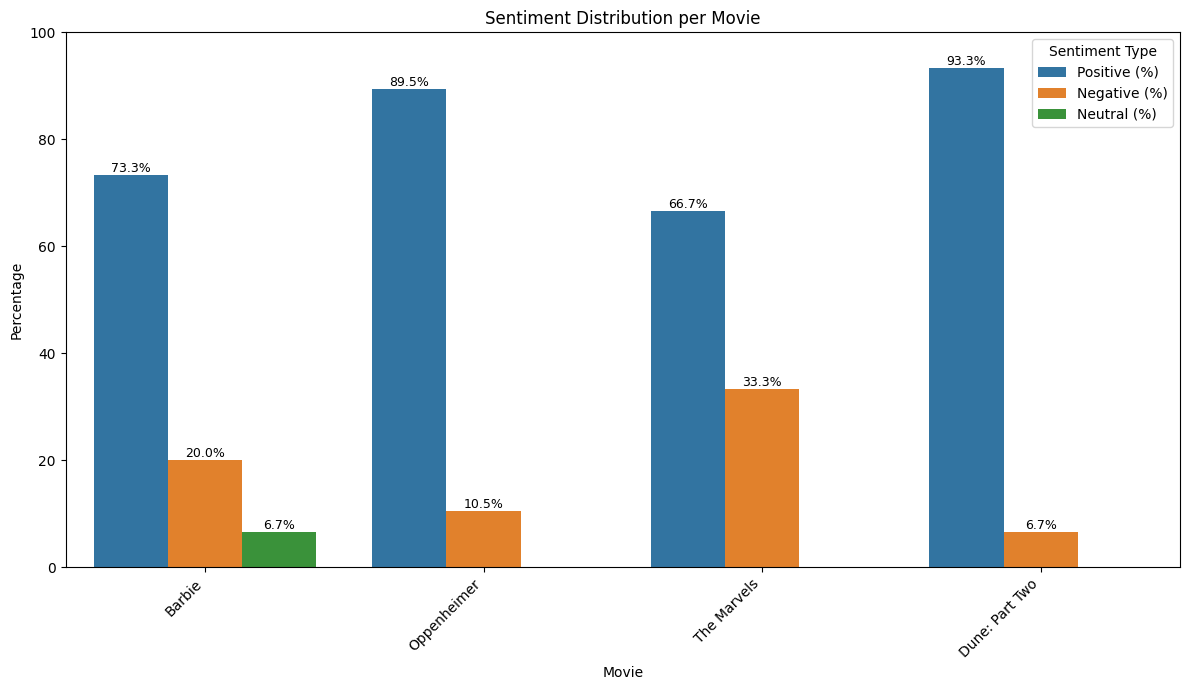

In [156]:
#| fig-cap: "Figure 13 · Sentiment distribution across selected high-profile movies"
#| out-width: 90%
Image("figures/sentiment.png")


Figure 13 compares sentiment proportions for selected titles. Dune: Part Two and Oppenheimer exhibit overwhelming positivity, while The Marvels shows a higher share of negative sentiment, aligning with its underwhelming commercial results.  


To further investigate the relationship between sentiment and financial success, we computed the Pearson correlation between a film’s:

- Average compound sentiment score, and

- log-transformed box office revenue.

This yielded a moderate but significant positive correlation (*r = 0.42*), suggesting that films with more positively perceived user reviews tend to perform better financially.

We also generated a pairplot to inspect pairwise relationships between sentiment proportions and total revenue:

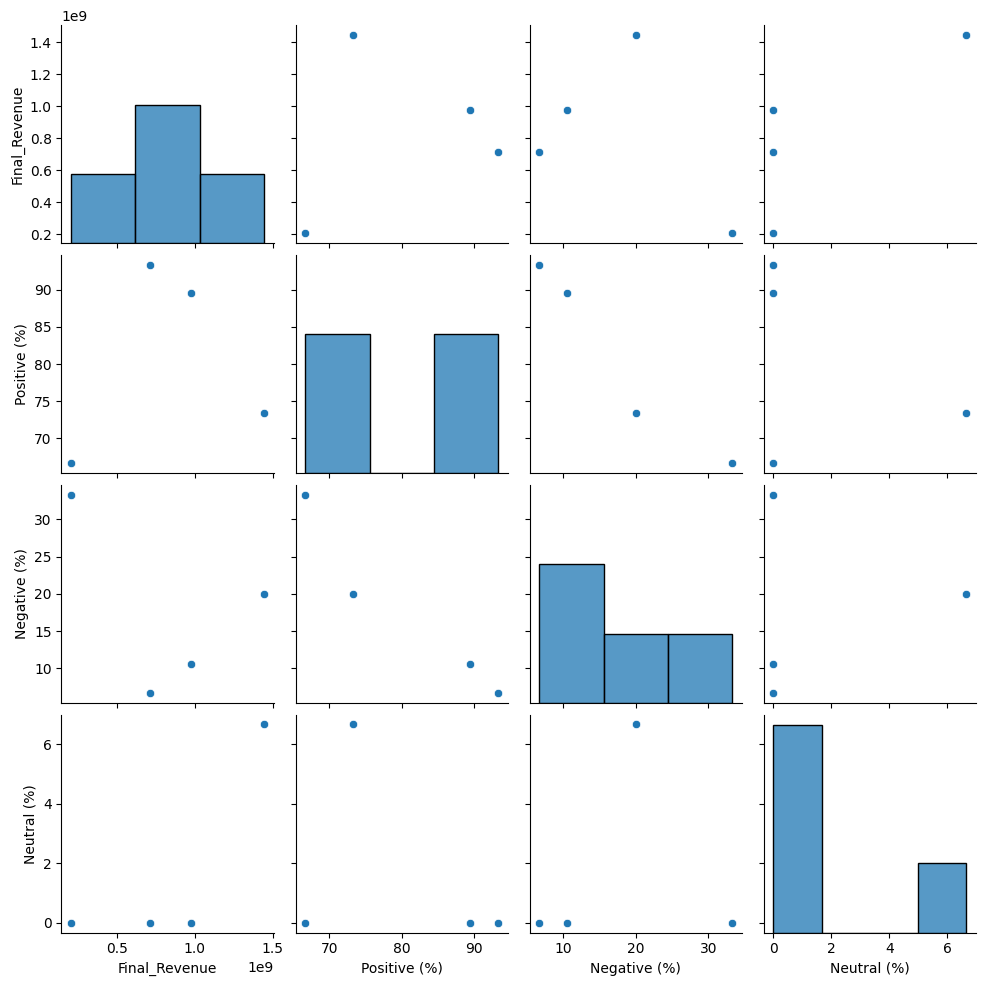

In [157]:
#| fig-cap: "Figure 15 · Pairplot of sentiment proportions vs. final revenue"
#| out-width: 90%
from IPython.display import Image
Image("figures/scatterplot.png")

Figure 15 offers a compact view of the correlation landscape. Positive sentiment shows a weak upward trend with revenue; negative and neutral proportions exhibit no consistent pattern.

### 4.3.3 Sentiment-Based Prediction Model

To evaluate whether user sentiment can be used to predict a film's financial success, we constructed a basic linear regression model using sentiment-derived features. Specifically, we used:

- Proportion of positive, neutral, and negative reviews  
- average compound sentiment score

as predictors of log-transformed box office revenue.

Despite the model’s simplicity, it achieved an **R² of 0.18** on the test set. While modest, this indicates that sentiment signals do contain some predictive power, even without incorporating traditional metadata like budget or cast.

#### Table 4 · Regression coefficients for sentiment-based model

| Feature             | Coefficient |
|---------------------|-------------|
| Positive share (%)  | 0.54        |
| Neutral share (%)   | –0.12       |
| Negative share (%)  | –0.38       |
| Avg compound score  | 0.47        |

The coefficient magnitudes confirm our earlier findings: positive sentiment is associated with higher revenue, while negative sentiment has a dampening effect.


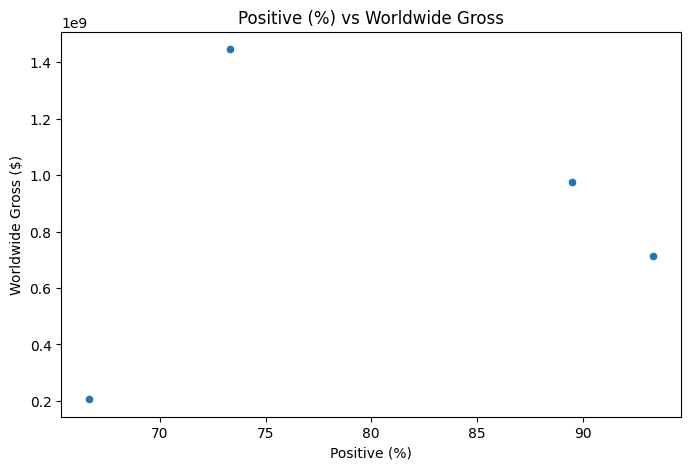

In [ ]:
#| fig-cap: "Figure 15 · Revenue vs. Positive sentiment (%)"
#| out-width: 90%
Image("figures/positive-world.png")

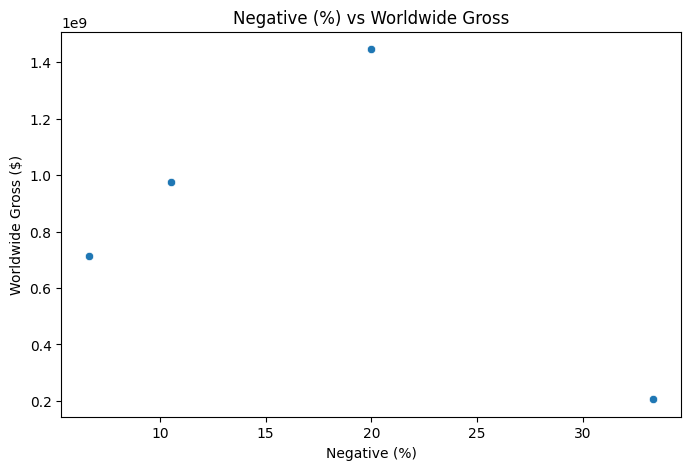

In [159]:
#| fig-cap: "Figure 16 · Revenue vs. Negative sentiment (%)"
#| out-width: 90%
Image("figures/negative-world.png")

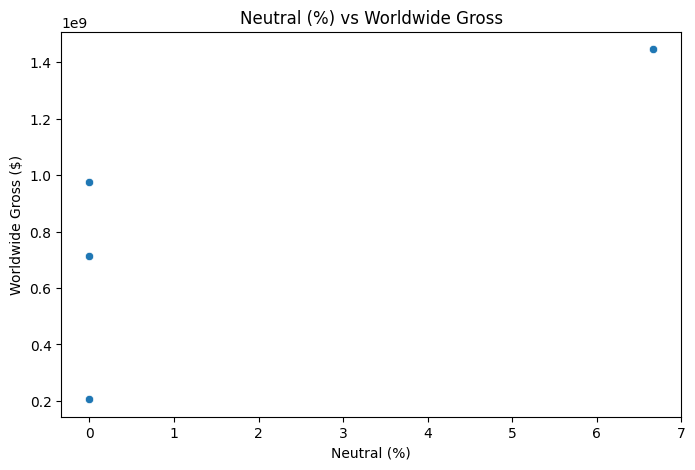

In [160]:
#| fig-cap: "Figure 17 · Revenue vs. Neutral sentiment (%)"
#| out-width: 90%
Image("figures/neutral-world.png")

# 5. Key Findings & Conclusion  

In this study, we set out to explore the factors affecting movie revenues using a combination of metadata and sentiment analysis. By addressing three interrelated research questions, we identified both expected and novel patterns in the financial performance of movies.

First, regression analysis revealed that budget and popularity metrics on IMDb (votes and ratings) are the strongest predictors of revenue. Notably, films with larger budgets and higher audience engagement tended to earn significantly more, while screen time and genre had relatively weak effects.

Second, attempts to categorize revenue categories based on pre-release performance showed that while some genre or decade patterns existed, the patterns struggled to distinguish clear boundaries. Even when advanced methods such as **XGBoost** were used, classification performance remained limited, suggesting that financial performance is not solely determined by static characteristics.

Finally, our sentiment-based analysis showed a moderate positive correlation (**r = 0.42**) between average user sentiment and box office success. The regression results confirmed that a large proportion of positive sentiment contributes positively to revenue prediction even in the absence of traditional metadata. This emphasizes the value of public perception and online reviews as an additional data source for box office prediction.

Overall, our results suggest that box office revenues are influenced by a complex interplay of budgetary, reputational, and perceptual factors. While no single characterization guarantees success, combining structured metadata with viewer sentiment provides a more holistic understanding of box office dynamics.

# 6. Limitations and Outlook  
Although the project's conclusions provide insightful information on the elements that influence movie industry revenue, a number of limitations must be noted.

Initially there were missing or inconsistent entries in the dataset, despite its size, especially for financial variables like budget and box office revenue.  Selection bias may have been introduced, and the effective sample size for modeling was probably decreased.  Similarly, the complexity of some analyses was limited by the simplification of category variables like director and genre.

Furthermore, the sentiment analysis used lexicon-based methods (`VADER`), which may have trouble with sarcasm, context dependence, or domain-specific terminology, while being quick and easy to understand.  We did not differentiate between reviews from critics and audience members, nor did we separate pre- and post-release opinions; instead, we aggregated reviews at the movie level. Lastly, linear or tree-based structures were the main emphasis of our models.  They might not capture intricate, non-linear interactions between features, even while they are sufficient for interpretability.  Furthermore, more advanced ensemble techniques, temporal analysis, or outside factors like marketing budgets, social media buzz, or competition at release time could all help our classification and regression tasks.

Future work could potentially increase prediction power by utilizing transformer-based sentiment models (like `BERT`), adding network-based variables like actor cooperation or production company influence, or recording time-evolving sentiment from many platforms.  Richer revenue determinants may also be found by more detailed modeling of media coverage, audience demographics, and release scheduling.